In [1]:
from duts import DutsDataset

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Generate trimaps

First, let's try to import the trained model and make a trimap prediction for an image.

In [2]:
trained_model = tf.keras.models.load_model('saved_models/segmentation_model')

In [23]:
ds=ds=DutsDataset("../DUTS")
print(len(ds.training_images), len(ds.test_images))

10553 5019


<AxesSubplot:>

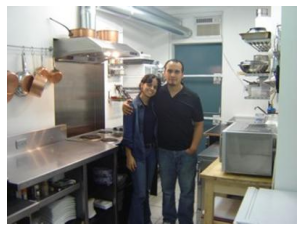

In [24]:
example_img=ds.test_images[np.random.randint(0, len(ds.test_images))]
example_img.show_image()

In [25]:
image=example_img.get_image()
image.shape

(300, 400, 3)

(224, 224, 3)


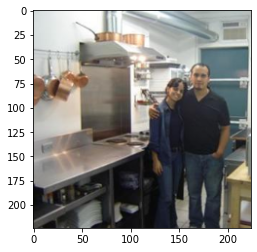

In [26]:
min_dim=np.min(image.shape[:2])
image_cropped=image[:min_dim, :min_dim, :]
image_scaled=cv2.resize(image_cropped, (224,224))
plt.imshow(image_scaled)
print(image_scaled.shape)

In [27]:
tensor=tf.convert_to_tensor([image_scaled.astype(np.float32) / 255.])

In [28]:
prediction=tf.argmax(trained_model.predict(tensor), -1)

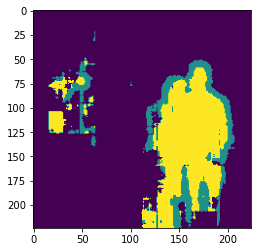

In [29]:
plt.imshow(prediction[0])

## Now update model

We did also an extra training on Collab, so let's update the model with the last checkpoint (epoch 203).

In [3]:
trained_model.load_weights("saved_models/segmentation_updates/checkpoints")


In [31]:
prediction_better=tf.argmax(trained_model.predict(tensor), -1)

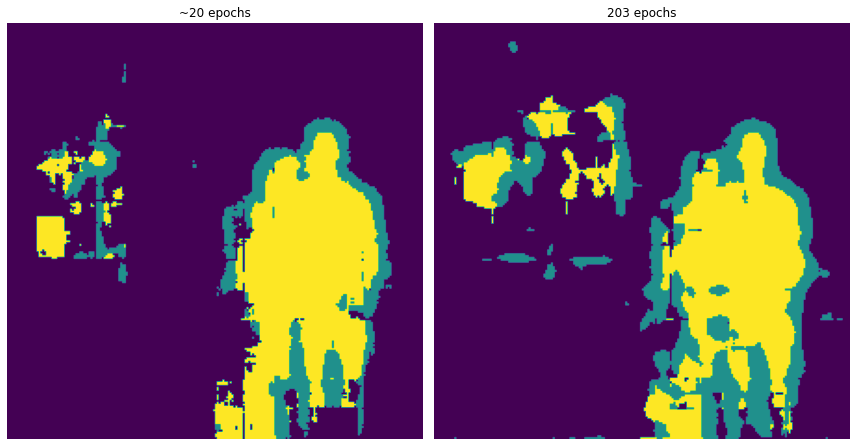

In [32]:
fig,axes=plt.subplots(1,2,figsize=(12,8), )
axes[0].imshow(prediction[0])
axes[0].set_axis_off()
axes[0].set_title("~20 epochs")
axes[1].imshow(prediction_better[0])
axes[1].set_axis_off()
axes[1].set_title("203 epochs")
fig.tight_layout()

## Make a processing pipeline

In [34]:
from generate_trimap import find_trimap, save_trimap

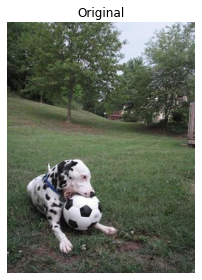

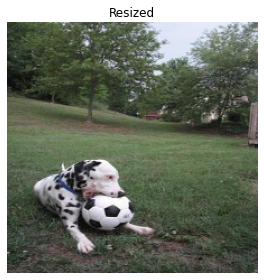

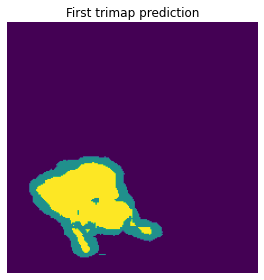

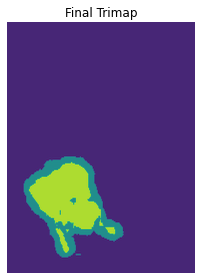

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
find_trimap("../DUTS/DUTS-TR/DUTS-TR-Image/n04254680_7831.jpg", show_steps=True)

### Cut out interesting part of the image

In [47]:
def find_trimap_1(img_path, show_steps=False):
    """Generates a trimap from an image file.

    :param img_path: Path to img file, all OpenCV compatible types supported.
    :param show_steps: Whether to show the intermediate steps with MPL, for debugging purposes.
    """

    # load image
    image = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    if show_steps:
        show_step(image, "Original")

    # Resize to 224,224
    image_resized = cv2.resize(image, (224, 224))
    if show_steps:
        show_step(image_resized, "Resized")

    # make tensor
    tensor = tf.convert_to_tensor([image_resized.astype(np.float32) / 255.0])

    # first prediction
    prediction_1 = (
        tf.argmax(trained_model.predict(tensor), -1)[0].numpy().astype(np.float32)
    )
    if show_steps:
        show_step(prediction_1, "First trimap prediction")

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    prediction_1 = cv2.morphologyEx(prediction_1, cv2.MORPH_OPEN, kernel)
    if show_steps:
        show_step(prediction_1, "Morphologic opened")
    return image,prediction_1


In [48]:
test_img, test_trimap=find_trimap_1("test_dog.jpg")

In [50]:
minx=np.flatnonzero(np.sum(test, axis=0))[0]
maxx=np.flatnonzero(np.sum(test, axis=0))[-1]
miny=np.flatnonzero(np.sum(test, axis=1))[0]
maxy=np.flatnonzero(np.sum(test, axis=1))[-1]

(minx,miny), (maxx,maxy)

((78, 71), (133, 162))

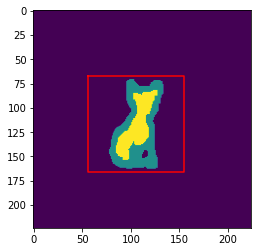

100

In [70]:
plt.figure()
plt.imshow(test_trimap)

square_size = np.round(np.max([maxx - minx, maxy - miny]) * 1.1).astype(int)

x_pad = (square_size - (maxx - minx)) // 2
y_pad = (square_size - (maxy - miny)) // 2

x_path = np.array(
    [
        [minx - x_pad, miny - y_pad],
        [maxx + x_pad, miny - y_pad],
        [maxx + x_pad, maxy + y_pad],
        [minx - x_pad, maxy + y_pad],
        [minx - x_pad, miny - y_pad],
    ]
)

plt.plot(x_path[:, 0], x_path[:, 1], "r")

plt.show()
square_size

139.28571428571428 104.28125 237.49999999999997 237.9375
140.3390625
21.06238839285716 3.3414062500000057
118 101 259 241


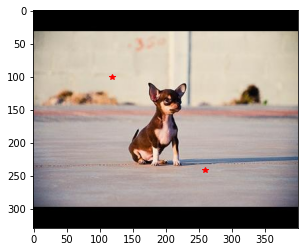

In [103]:
plt.imshow(test_img)
height, width = test_img.shape[:2]
x_scale = 224.0 / width
y_scale = 224.0 / height

x0 = minx / x_scale
y0 = miny / y_scale

x1 = maxx / x_scale
y1 = maxy / y_scale
print(x0, y0, x1, y1)

square_size=max(x1-x0, y1-y0) * 1.05
print(square_size)

x_pad = (square_size - (x1 - x0)) / 2
y_pad = (square_size - (y1 - y0)) / 2
print(x_pad, y_pad)

x0-=x_pad
y0-=y_pad
x1+=x_pad
y1+=y_pad

x0=int(round(x0))
x1=int(round(x1))
y0=int(round(y0))
y1=int(round(y1))
print(x0, y0, x1, y1)

plt.plot([x0, x1], [y0, y1], "r*")

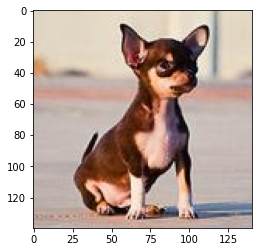

In [102]:
cropped_image=test_img[y0:y1, x0:x1]
plt.imshow(cropped_image)

In [91]:
print(x0, y0, x1, y1)

97 80 280 262
